# Fraud prediction with the Multi-Subset Observation Undersampling (OU) 
## Model by Perols et al. (2017)

### Background

The phenomenon of fraud is rare but expensive (to the industry and its customers). However it is a fascinating aspect of human behavior, and it's a worthy subject of study. Why? The problems that englobe its understanding are far from trivial.

Fraud, to be possible, needs three elements:
- A supply of motivated fraudsters.
- Availability of suitable targets.
- The absence of vigilantes.

Motivated offenders and visible targets will always be available. And we (the scientists, engineers, thinkers, etc.), could be seen as one of the layers of 'vigilantes,' adept enough to prevent the attacks of these sophisticated thieves.

One of the main challenges is that fraudsters adapt to our defenses, and we (the vigilantes) have to engineer new barriers, playing always an arms race with the fraudsters. This phenomenon is known as the Red Queen Effect by evolutionary biologists and could be seen by some people as a headache that burns resources. I myself, think of it as a drive to innovation.

One of the solutions to overcome this problem is to detect fraud instances in real-time, or even forecast them. This can be done by constructing predictive models with math as our building blocks, computer operations as our cement, and science and literature as our blue prints. Because of the Red Queen Effect, these models will need a constant re-think.

Hence, here is my attempt to demonstrate how this can be done.


José P. Barrantes, <br>
Data Scientist

17/Dec/2019

### About this project and methodology

The strength of this methodology is in the data preprocessing phase, it is designed to address the class unbalance problem. This pre-processing architecture consists in generating several training subsets, each one will contain a copy of all the instances of the minority class (the frauds in this case) available in the training set, and several random instances of the majority class.
<br> <br>
Each of these subsets is used to train a classifier, hoping that it will learn better to recognise the minority class. Later, groups of classifiers are combined in a global (ensembled) classifier who can discern better between classes. An analogy can be used to explain this: each individual model is a voter, and it chooses to which class belongs the instance we are testing, in the end, we count the votes to take our decision.
<br> <br>
Here we will use a 'soft-voting' system, as part of our process of decision making. This means that we run our models with an example transaction, we get the probability (of the example belonging to the fraud class) of each model, and we average them. If the value excedes a fixed threshold, we classify the instance as a positive case. This threshold is determined by an algorithm that minimizes our performance metric, the Expected Cost of Misclassification.
<br> <br>
So, we should have an ensemble algorithm who is able to recognize fraud cases and differenciate them from true transactions. You can find more details about the model design and methodology in the file README.pdf.

### Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit  # To do stratified sampling.
import model_metrics_parallel as mmp # Custom library to manage some metrics needed for fine-tuning and optimization.
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from ensemble_model import Ensemble_model # Also, a custom library made to manage the construction of ensembles with the required specs.
%matplotlib inline
import matplotlib.pyplot as plt # To plot the results.

### Data description

Variables:
- V1 - V28: results of a dimensionality reduction from PCA.
- Amount:   transaction amount.
- Time:     relative time of the transaction event. 
- Class:    0 true transaction. 1 fraudulent transaction.

You can find this data set with all the details in Kaggle:
https://www.kaggle.com/mlg-ulb/creditcardfraud

### Load data

In [4]:
raw_data = pd.read_csv('source_data/creditcard.csv')

### Data pre-processing

We get rid of the Time variable cause its scale could affect the training.

In [5]:
raw_data.drop('Time', axis=1, inplace=True)

In [6]:
# The 'Amount' column covers a huge range. Convert to log-space.
eps=0.001 # to avoid errors due the log operation
raw_data['Log Ammount'] = np.log(raw_data.Amount + eps)

# Eliminate the original 'Amount'
raw_data.drop('Amount', axis=1, inplace=True)

### Data partition

We want our test set to be representative of the two-class categories. Hence we do a stratified partition of the sets. 
The test set is only to check (at the end) if our model can generalize to new data. We will train our models with the training set.

In [7]:
# stratified sapling based on the fraud category
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data['Class']):
    strat_train_set = raw_data.loc[train_index]
    strat_test_set  = raw_data.loc[test_index]
    
# we wont use the test_set until the final phase. Just remember it is there.

In [8]:
len(strat_train_set)

227845

Also, we will need a validation set to fine-tune our model hyperparameters, and to evaluate other metrics:

In [9]:
strat_train_set_1 = strat_train_set.reset_index() # without this, the method would sample empty indexes.

for train_index, val_index in split.split(strat_train_set_1, strat_train_set_1['Class']):
    val_set    = strat_train_set_1.loc[val_index]
    train_set  = strat_train_set_1.loc[train_index]

In [10]:
# get rid of the new index col
val_set.drop('index', axis=1, inplace=True)
train_set.drop('index', axis=1, inplace=True)

Lets check the class proportions in the sets:

In [11]:
strat_train_set['Class'].value_counts() / len(strat_train_set)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [12]:
strat_test_set['Class'].value_counts() / len(strat_test_set)

0    0.99828
1    0.00172
Name: Class, dtype: float64

In [13]:
train_set['Class'].value_counts() / len(train_set)

0    0.998272
1    0.001728
Name: Class, dtype: float64

In [14]:
val_set['Class'].value_counts() / len(val_set)

0    0.998266
1    0.001734
Name: Class, dtype: float64

So, just around 0.2% of our instances are frauds.

## Build of Observation Undersampling architecture

According to Perols _et al._ (2017), we will need all the fraudulent instances for each of our OU subsets. So, we separate 2 subsets.

In [15]:
frauds        = train_set.loc[train_set['Class'] == 1]
true_transac  = train_set.loc[train_set['Class'] == 0]

# the shuffled sample could produce duplicates, so we will drop them
frauds        = frauds.drop_duplicates()
true_transac  = true_transac.drop_duplicates()

In [16]:
# so, we are left with these fraud cases for our training
len(frauds)

306

In [17]:
len(val_set.loc[val_set['Class'] == 0]) / len(val_set.loc[val_set['Class'] == 1])
# Of 577 transaction, one is a fraud

575.8227848101266

### Creation of Observation Undersampling (OU) subsets

A function to generate our subsets:

In [18]:
def generate_ou_subsets(subset_amount=12, as_np=False):
    """
    This function generates our training Observation undersampling subsets.
    Each subset cotains all the training fraud instances, and the total size of the subset is choosen so we have a 20% fraud instances.
    
    Returns:
        A list with the amount of training subsets required by the user. Perols et al. (2017) recommends 12.
    """
    
    true_transc_amount = 1500 - len(frauds) # this leave around 20% of fraud cases in each subset
    ou_subsets         = []                 # a list of dataframes. Each df is the shuffled true transactions, plus the all the frauds available.
    slice_index_i      = 0                  # the start of our df chunk
    slice_index_f      = true_transc_amount # the end of our df chunk
    
    ## Next is what the function does if we want np arrays
    if as_np == True:
        labels_subset      = []     # a list with the labels, if we opt for the np structures
        bool_labels        = []
    
        i = 0
        while i < subset_amount:
            ou_subsets.append( np.array(pd.concat([true_transac[slice_index_i:slice_index_f], frauds]).drop(['Class'], axis=1)) ) # the pandas df is inputed to the list as a np.array. Also the variables Class and index are excluded.
            labels_subset.append( np.array(pd.concat([true_transac[slice_index_i:slice_index_f], frauds]).Class) ) # the pandas df is inputed to the list as a np.array. Also the variables Class and index are excluded.
            bool_labels.append( np.array(pd.concat([true_transac[slice_index_i:slice_index_f], frauds]).Class) != 0 )
            
            i += 1
            slice_index_i += true_transc_amount
            slice_index_f += true_transc_amount
            
        return ou_subsets, labels_subset, bool_labels
        
    # And if we want the result as pandas df:
    i = 0
    while i < subset_amount:
        ou_subsets.append( pd.concat([true_transac[slice_index_i:slice_index_f], frauds]) )
        
        i += 1
        slice_index_i += true_transc_amount
        slice_index_f += true_transc_amount
                
    return ou_subsets

In [19]:
# we can do this, to gernerate subsets for a 10-fold cross validation. 120 in total.
training_subsets_10_fold = generate_ou_subsets(subset_amount=12*10) 

### Let's use our ou subsets to train some models:

SVMs:

With each subset, we train a support vector machine (SVM). This trained models are stored in the list 'svm_models.'

In [20]:
svm_models = []                         # List to store our models
n_mod = 0
for subset in training_subsets_10_fold:
    X = subset.drop(['Class'], axis=1)  # Features
    y = subset.Class                    # Labels
    svm_models.append(SVC(kernel='rbf', probability=True, gamma='auto').fit(X, y)) # the gamma parameter must be double cheched
    print('Model ' + str(n_mod) + ' appended.')  # This just to know the progress
    n_mod += 1

Model 0 appended.
Model 1 appended.
Model 2 appended.
Model 3 appended.
Model 4 appended.
Model 5 appended.
Model 6 appended.
Model 7 appended.
Model 8 appended.
Model 9 appended.
Model 10 appended.
Model 11 appended.
Model 12 appended.
Model 13 appended.
Model 14 appended.
Model 15 appended.
Model 16 appended.
Model 17 appended.
Model 18 appended.
Model 19 appended.
Model 20 appended.
Model 21 appended.
Model 22 appended.
Model 23 appended.
Model 24 appended.
Model 25 appended.
Model 26 appended.
Model 27 appended.
Model 28 appended.
Model 29 appended.
Model 30 appended.
Model 31 appended.
Model 32 appended.
Model 33 appended.
Model 34 appended.
Model 35 appended.
Model 36 appended.
Model 37 appended.
Model 38 appended.
Model 39 appended.
Model 40 appended.
Model 41 appended.
Model 42 appended.
Model 43 appended.
Model 44 appended.
Model 45 appended.
Model 46 appended.
Model 47 appended.
Model 48 appended.
Model 49 appended.
Model 50 appended.
Model 51 appended.
Model 52 appended.
Mod

Logistic:

And, we also fit logistic regressions with the subsets. Later we will do ensembles with them.

In [21]:
logistic_models = []
n_mod = 0
for subset in training_subsets_10_fold:
    X = subset.drop(['Class'], axis=1)
    y = subset.Class
    logistic_models.append(LogisticRegression(solver='newton-cg').fit(X, y)) 
    print('Model ' + str(n_mod) + ' appended.')
    n_mod += 1

Model 0 appended.
Model 1 appended.
Model 2 appended.
Model 3 appended.
Model 4 appended.
Model 5 appended.
Model 6 appended.
Model 7 appended.
Model 8 appended.
Model 9 appended.
Model 10 appended.
Model 11 appended.
Model 12 appended.
Model 13 appended.
Model 14 appended.
Model 15 appended.
Model 16 appended.
Model 17 appended.
Model 18 appended.
Model 19 appended.
Model 20 appended.
Model 21 appended.
Model 22 appended.
Model 23 appended.
Model 24 appended.
Model 25 appended.
Model 26 appended.
Model 27 appended.
Model 28 appended.
Model 29 appended.
Model 30 appended.
Model 31 appended.
Model 32 appended.
Model 33 appended.
Model 34 appended.
Model 35 appended.
Model 36 appended.
Model 37 appended.
Model 38 appended.
Model 39 appended.
Model 40 appended.
Model 41 appended.
Model 42 appended.
Model 43 appended.
Model 44 appended.
Model 45 appended.
Model 46 appended.
Model 47 appended.
Model 48 appended.
Model 49 appended.
Model 50 appended.
Model 51 appended.
Model 52 appended.
Mod

### Ensembling our models and finding the optimal cutoff

Let us generate 10 ensembled SVM models. Each of these ensembles is composed of 12 models. <br>
I've developed the Ensemble_model class in order to manage the ensembled models, their performance metrics, and the predictions that can be done with them. The class constructor receives a list of pre-trained models, the test set (or the set of instances we want to classify), and the cutoff.

### The cutoff (fine tuning of the model)

The cutoff is the threshold who defines it until what probability it's okay to recognize the instance as a fraud. The optimal cutoff is the one who renders the minimum ECM, so we want to minimize ECM. It will be determined by using the validation set, and the method "find_min_ECM()" that I coded.

We use the validation set to avoid our models from peeping at the test data set.

For the SVM:

In [58]:
ensenmble_svms_calibration = []
chunk_i = 0
chunk_f =12
for n in range(0,10):
    ensenmble_svms_calibration.append(Ensemble_model(svm_models[chunk_i:chunk_f], val_set, 0.9))
    chunk_i += 12
    chunk_f += 12
    print("Ensemble " + str(n) + " ready.")

Ensemble 0 ready.
Ensemble 1 ready.
Ensemble 2 ready.
Ensemble 3 ready.
Ensemble 4 ready.
Ensemble 5 ready.
Ensemble 6 ready.
Ensemble 7 ready.
Ensemble 8 ready.
Ensemble 9 ready.


In [59]:
ens_n = 0
for ensemble in ensenmble_svms_calibration:
    print("The min(ECM) for ensemble " + str(ens_n) + " is: " + str(ensemble.find_min_ECM()) )
    ens_n += 1

The min(ECM) for ensemble 0 is: 0.7000000000000001
The min(ECM) for ensemble 1 is: 0.7000000000000001
The min(ECM) for ensemble 2 is: 0.8
The min(ECM) for ensemble 3 is: 0.7000000000000001
The min(ECM) for ensemble 4 is: 0.8
The min(ECM) for ensemble 5 is: 0.8
The min(ECM) for ensemble 6 is: 0.7000000000000001
The min(ECM) for ensemble 7 is: 0.8
The min(ECM) for ensemble 8 is: 0.8
The min(ECM) for ensemble 9 is: 0.8


Hence, the optimal cutoff for our SVMs is:

In [80]:
svms_cutoff = 0
for ensemble in ensenmble_svms_calibration:
    svms_cutoff += ensemble.min_ECM / len(ensenmble_svms_calibration)
    
svms_cutoff + 0.05

0.8099999999999999

For the logistics:

In [60]:
ensenmble_logistic_models_calibration = []
chunk_i = 0
chunk_f =12
for n in range(0,10):
    ensenmble_logistic_models_calibration.append(Ensemble_model(logistic_models[chunk_i:chunk_f], val_set, 0.9))
    chunk_i += 12
    chunk_f += 12
    print("Ensemble " + str(n) + " ready.")

Ensemble 0 ready.
Ensemble 1 ready.
Ensemble 2 ready.
Ensemble 3 ready.
Ensemble 4 ready.
Ensemble 5 ready.
Ensemble 6 ready.
Ensemble 7 ready.
Ensemble 8 ready.
Ensemble 9 ready.


In [61]:
ens_n = 0
for ensemble in ensenmble_logistic_models_calibration:
    print("The min(ECM) for ensemble " + str(ens_n) + " is: " + str(ensemble.find_min_ECM()) )
    ens_n += 1

The min(ECM) for ensemble 0 is: 0.6000000000000001
The min(ECM) for ensemble 1 is: 0.6000000000000001
The min(ECM) for ensemble 2 is: 0.8
The min(ECM) for ensemble 3 is: 0.6000000000000001
The min(ECM) for ensemble 4 is: 0.6000000000000001
The min(ECM) for ensemble 5 is: 0.8
The min(ECM) for ensemble 6 is: 0.6000000000000001
The min(ECM) for ensemble 7 is: 0.6000000000000001
The min(ECM) for ensemble 8 is: 0.6000000000000001
The min(ECM) for ensemble 9 is: 0.6000000000000001


In [79]:
logistics_cutoff = 0
for ensemble in ensenmble_logistic_models_calibration:
    logistics_cutoff += ensemble.min_ECM / len(ensenmble_logistic_models_calibration)
    
logistics_cutoff + 0.05

0.6900000000000002

### Ensembling the models

Here we are taking our 120 individual models to create 10 ensembles, made of 12 models each one. So we can say, that each ensemble is a global model consisting of 12 voters.
<br> <br>
The instances of the class Ensemble_model renders the test metric at once, cause we load the test set on them.

In [74]:
ensenmble_svms = []
chunk_i = 0
chunk_f =12
for n in range(0,10):
    ensenmble_svms.append(Ensemble_model(svm_models[chunk_i:chunk_f], strat_test_set, 0.8))
    chunk_i += 12
    chunk_f += 12
    print("Ensemble " + str(n) + " ready.")

Ensemble 0 ready.
Ensemble 1 ready.
Ensemble 2 ready.
Ensemble 3 ready.
Ensemble 4 ready.
Ensemble 5 ready.
Ensemble 6 ready.
Ensemble 7 ready.
Ensemble 8 ready.
Ensemble 9 ready.


And now we do the same with the logistic models:

In [72]:
ensenmble_logistic_models = []
chunk_i = 0
chunk_f =12
for n in range(0,10):
    ensenmble_logistic_models.append(Ensemble_model(logistic_models[chunk_i:chunk_f], strat_test_set, 0.7))
    chunk_i += 12
    chunk_f += 12
    print("Ensemble " + str(n) + " ready.")

Ensemble 0 ready.
Ensemble 1 ready.
Ensemble 2 ready.
Ensemble 3 ready.
Ensemble 4 ready.
Ensemble 5 ready.
Ensemble 6 ready.
Ensemble 7 ready.
Ensemble 8 ready.
Ensemble 9 ready.


### Lets compare the models logistic and SVM ensembles

To do this we average the information of the lists of ensembles. Just to have a better general idea of their performance.

In [122]:
def averaged_ensemble_metrics(ensembles):
    """
    This function is to get the performance metrics of interest.
    
    Receives: a list of ensembled models.
    """
    fn = []
    fp = []
    tp = []
    samp_size = []
    sensitiv  = []
    specific  = []
    ECM       = []

    for ensemble in ensembles:
        fn.append(ensemble.FNs)
        fp.append(ensemble.FPs)
        tp.append(ensemble.TPs)
        samp_size.append(ensemble.sample_size)
        sensitiv.append(ensemble.sensitivity)
        specific.append(ensemble.specificity)
        ECM.append(ensemble.ECM)
    
    print("False negatives: \t" + str(np.mean(fn)))
    print("False positives: \t" + str(np.mean(fp)))
    print("True positives: \t"  + str(np.mean(tp)))
    print("Sample size: \t\t"   + str(np.mean(samp_size)))
    print("Sensitivity: \t\t"   + str(np.mean(sensitiv)))
    print("Specificity: \t\t"   + str(np.mean(specific)))
    print("ECM: \t\t\t"         + str(np.mean(ECM)) + "\n")
    
    return [np.mean(fn), np.mean(fp), np.mean(tp), np.mean(sensitiv), np.mean(ECM)]
    

#### Lets look at the average of the ten model (logistics vs. SVMs)

In [143]:
# We'll use this to compare the performance of our models
metric_labels = ['FNs', 'FPs', 'TPs', 'Sensitivity', 'ECM']
svms_metrics  = averaged_ensemble_metrics(ensenmble_svms)    # This variable will be used later to plot performance.

False negatives: 	11.2
False positives: 	119.0
True positives: 	86.8
Sample size: 		56962.0
Sensitivity: 		0.8857142857142858
Specificity: 		0.997907287563309
ECM: 			0.022651584733499475



In [144]:
# We'll use this to compare the performance of our models
logistic_metrics  = averaged_ensemble_metrics(ensenmble_logistic_models)  # This variable will be used later to plot performance.

False negatives: 	11.0
False positives: 	285.7
True positives: 	87.0
Sample size: 		56962.0
Sensitivity: 		0.8877551020408163
Specificity: 		0.9949757315700619
ECM: 			0.02519820445201153



They're getting just 11 false negatives, and a sensitivity of almost 90%

## But another big question remains: Does our OU subsampling model perform better that a naïve one?

### Lets check this out

SVM:

In [47]:
len(train_set) # Too big. My laptop cannot train a SVM with so many data points.

182276

In [1]:
len(val_set)   # Lets try this set.

NameError: name 'val_set' is not defined

In [85]:
# The train_set is too big to be used as trainig set (my machine can't handle it).
# So we will train this naïve model by using the val_set, which is much maller than train_set.

naive_svm = SVC(kernel='rbf', probability=True, gamma='auto').fit(val_set.drop('Class', axis=1), val_set.Class)
naive_svm_metrics = mmp.Model_metrics(naive_svm, strat_test_set, 0.9 )

Logistic:

In [81]:
# trained with the same dataset as naive_svm
naive_logistic = LogisticRegression(solver='newton-cg').fit(val_set.drop('Class', axis=1), val_set.Class)
naive_logistic_metrics = mmp.Model_metrics(naive_logistic, strat_test_set, 0.8 )

In [82]:
# trained with the full trainset
naive_logistic_full_ds = LogisticRegression(solver='newton-cg').fit(train_set.drop('Class', axis=1), train_set.Class)
naive_logistic_full_ds_metrics = mmp.Model_metrics(naive_logistic_full_ds, strat_test_set, 0.7 )

In [99]:
naive_svm_metrics.summary()

False negatives: 	51
False positives: 	7
True positives: 	47
Sample size: 		56962
Sensitivity: 		0.47959183673469385
Specificity: 		0.9998768992684299
ECM: 			0.09379583151493574



In [145]:
# We'll use this to compare the performance of our models
svm_naive_metrics = [naive_svm_metrics.FNs,
                     naive_svm_metrics.FPs,
                     naive_svm_metrics.TPs,
                     naive_svm_metrics.sensitivity, 
                     naive_svm_metrics.ECM]

In [100]:
naive_logistic_metrics.summary()

False negatives: 	42
False positives: 	12
True positives: 	56
Sample size: 		56962
Sensitivity: 		0.5714285714285714
Specificity: 		0.9997889701744513
ECM: 			0.07735262078945253



In [146]:
# We'll use this to compare the performance of our models
logistic_naive_metrics = [naive_logistic_metrics.FNs,
                          naive_logistic_metrics.FPs,
                          naive_logistic_metrics.TPs,
                          naive_logistic_metrics.sensitivity,
                          naive_logistic_metrics.ECM]

In [86]:
naive_logistic_full_ds_metrics.summary()

False negatives: 	40
False positives: 	11
True positives: 	58
Sample size: 		56962
Sensitivity: 		0.5918367346938775
Specificity: 		0.9998065559932471
ECM: 			0.07366167109781448



## Saving models

Some time the training takes a lot of time, and computing power. Hence we can save our modes in pickle files:

In [17]:
# Save models
import pickle

with open('trainedmodels_backups/ensemble_svms_data.pkl', 'wb') as output:
    pickle.dump(ensenmble_svms, output, pickle.HIGHEST_PROTOCOL)

with open('trainedmodels_backups/ensemble_logistics_data.pkl', 'wb') as output:
    pickle.dump(ensenmble_logistic_models, output, pickle.HIGHEST_PROTOCOL)

And load them once we require them:

In [ ]:
# Load models
with open('trainedmodels_backups/ensemble_svms_data.pkl', 'rb') as input:
    ensenmble_svms = pickle.load(input)
    
with open('trainedmodels_backups/ensemble_logistics_data.pkl', 'rb') as input:
    ensenmble_logistic_models = pickle.load(input)

## Results

First we summarize all the useful performance metrics of the models we want to compare.

In [147]:
metric_labels.append('Model')
metric_labels.append('Type')

svms_metrics.append('SVMs')
svms_metrics.append('OU')

logistic_metrics.append('Logistics')
logistic_metrics.append('OU')

svm_naive_metrics.append('SVMs')
svm_naive_metrics.append('Naive')

logistic_naive_metrics.append('Logistics')
logistic_naive_metrics.append('Naive')

And we will put then in a dataframe:

In [148]:
final_metrics = pd.DataFrame(columns=metric_labels, data=[svms_metrics, logistic_metrics, svm_naive_metrics, logistic_naive_metrics])
final_metrics

,FNs,FPs,TPs,Sensitivity,ECM,Model,Type
0,11.2,119.0,86.8,0.885714,0.022652,SVMs,OU
1,11.0,285.7,87.0,0.887755,0.025198,Logistics,OU
2,51.0,7.0,47.0,0.479592,0.093796,SVMs,Naive
3,42.0,12.0,56.0,0.571429,0.077353,Logistics,Naive


In [170]:
final_metrics.round(decimals=3)

,FNs,FPs,TPs,Sensitivity,ECM,Model,Type
0,11.2,119.0,86.8,0.886,0.023,SVMs,OU
1,11.0,285.7,87.0,0.888,0.025,Logistics,OU
2,51.0,7.0,47.0,0.480,0.094,SVMs,Naive
3,42.0,12.0,56.0,0.571,0.077,Logistics,Naive


At first glance, we can see that the OU models are more sensible and have the lower ECM.

### Lets plot these results

ECM:

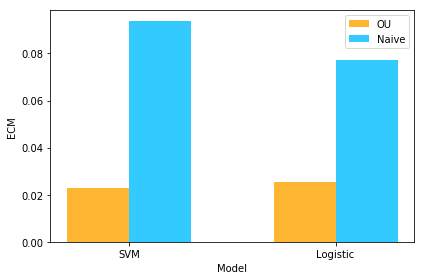

In [164]:
# data to plot
n_groups   = 2
ECMs_OU    = final_metrics[final_metrics.Type == 'OU'].ECM
ECMs_Naive = final_metrics[final_metrics.Type == 'Naive'].ECM

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, ECMs_OU, bar_width,
alpha=opacity,
color='orange',
label='OU')

rects2 = plt.bar(index + bar_width, ECMs_Naive, bar_width,
alpha=opacity,
color='deepskyblue',
label='Naive')

plt.xlabel('Model')
plt.ylabel('ECM')
#plt.title('ECM by type of model')
plt.xticks(index + bar_width/2, ('SVM', 'Logistic'))
plt.legend()

plt.tight_layout()
plt.show()

Sensitivity (the proportion of actual positives that are correctly classified as such):

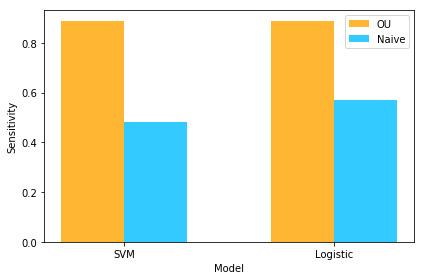

In [167]:
# data to plot
n_groups   = 2
Sensitivity_OU    = final_metrics[final_metrics.Type == 'OU'].Sensitivity
Sensitivity_Naive = final_metrics[final_metrics.Type == 'Naive'].Sensitivity

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, Sensitivity_OU, bar_width,
alpha=opacity,
color='orange',
label='OU')

rects2 = plt.bar(index + bar_width, Sensitivity_Naive, bar_width,
alpha=opacity,
color='deepskyblue',
label='Naive')

plt.xlabel('Model')
plt.ylabel('Sensitivity')
#plt.title('ECM by type of model')
plt.xticks(index + bar_width/2, ('SVM', 'Logistic'))
plt.legend()

plt.tight_layout()
plt.show()

## Conclusions

The Observation Undersamplig model performed very well when compared with naive approaches.
The ensembled architectures resulted almost twice as sensible when compared when the naive approaches.
The ECM Was 3 times lower in the OU ensembles that the naive models. This means that the model proposed by Perols and his colleagues (2017) will produce less false positives and less false negatives. It is recommended to use this model architecture in data-driven decision making when class unbalances are an issue.

This methodology could be enhanced by Feature Engineering and causal reasoning. Sadly, the variables in the available data set ar anonymous, and little can be done to engineer features.

## Consulted resources

Literature:
- Perols, J. L., Bowen, R. M., Zimmermann, C., & Samba, B. (2017). Finding needles in a haystack: Using data analytics to improve fraud prediction. The Accounting Review, 92, 221-245.
- Ramamoorti, S. (2008). The psychology and sociology of fraud: Integrating the behavioral sciences component into fraud and forensic accounting curricula. Issues in Accounting Education, 23, 521-533. 

Online:
- Machine Learning Group - ULB. (2018, March). Credit Card Fraud Detection: Anonymized credit card transactions labeled as fraudulent or genuine, Version 3. Consulted in October, 2019 from https://www.kaggle.com/mlg-ulb/creditcardfraud/